# Amazon Reviews Analysis
---
<b>By David Penny<b>

<b>Problem Statement:<b>
- With amazon nearing ½ billion products, users turn to reviews to inform their purchase decisions. The question is how helpful is each review?


<b>Understanding the Problem<b>
- Yelp has an algorithm that classifies reviews as “recommended” or “not-recommended” and is very effective at maintaining an honest review of each establishment.
- Amazon removes reviews it deems unauthentic or that violate its Terms of Use. However many “unhelpful” reviews seem to remain. Sellers can also be maliciously attacked when competitors order blatently obvious reviews for another seller, forcing Amazon to automatically shut the seller down.


<b>What is an Unhelpful Review?<b>

Unhelpful reviews can be any combination of the following:
- Too Short.
- Too Long.
- Too complicated to read.
- Too simplistic.
- Overly negative
- Overly positive
- Containing toxic or otherwise strong negative sentiment.
- Falsified or dishonest.
- Incentivised

<b>Levels of Analysis<b>
    
While there are many avenues to tackle this problem and different levels of analysis possible. This project will only focus on the first level and if more time exists, pursue the second level.
    
Level 1: Feature Engineering
- Engineer features seen in Table 1 below. Train and test a variety of models to attempt to reach the highest accuracy.
    
Level 2: User Behavior & Product Trust
- www.ReviewMeta.com does this exceptionally well. They scrape each product, its reviews and the metadata from each of the users profile pages, and then determine the following:
    
    - Check for deleted reviews  (Has the product lost reviews over time?)
    - Reviewer ease (Does the reviewer always give '5-star' reviews?)
    - Rating trend (How has the review rating changed over time?)
    - Unverified purchases (Is the customer verified for purchasing the product?)
    - Word count comparison (How do the word counts compare review to review?)
    - Phrase repetition (Are the reviews similar in any way?)
    - Suspicious reviewers (one-hit wonders, never-verified reviewers, single-day reviewers)
    - Overlapping review history (Has the same customer reviewed the same product?)
    - Brand repeats (Do the same customers review all the same products?)
    
This creates a exceptionally powerful understanding of not just the trustworthiness of the review, but the trustworthiness of the reviewer.

<b>Goal<b>

- Engineer the correct features in the correct combination to attain the highest possible accuracy at labeling reviews as 'falsified'.

<b>Packages, programs and libraries Required<b>
- Sklearn
- textstat
- [Stanford CoreNLP](https://stanfordnlp.github.io/CoreNLP/index.html)
- Java's JDK

<b>Ackowledgements<b>
- Dataset sourced from github repository: [Deception-Detection-on-Amazon-reviews-dataset](https://github.com/aayush210789/Deception-Detection-on-Amazon-reviews-dataset)
- Yao, Yao; Angelov, Ivelin; Rasmus-Vorrath, Jack; Lee, Mooyoung; and Engels, Daniel W. (2018) "Yelp’s Review Filtering Algorithm,"
SMU Data Science Review: Vol. 1 : No. 3 , Article 3.
Available at: https://scholar.smu.edu/datasciencereview/vol1/iss3/3
- Hossain, Md Forhad, "Fake Review Detection using Data Mining" (2019). MSU Graduate Theses. 3423.
https://bearworks.missouristate.edu/theses/3423

<b>Feature Engineering:<b>

Features to Add | Description | Example
------------- | ------------- | -------------
falsified | The label indicating if the review was falsified or not | 1
rating | The star rating the customer rated the product from 1-5 | 3
verified_purchase | Returns wether or not the customer purchased the product. | 1
sentiment | Returns the overall sentiment of the review. | 0
num_words_in_text | Returns the total number of words in the text | 23
num_stopwords| Returns the total number of stop words. | 12
num_words_in_text_no_stop | Returns the total number of words in the text not counting stop words. | 9
num_unique_words | Returns the number of unique words in the text. | 17
mean_word_len| Returns the average word length in the text. | 4
num_chars| Returns the total number of characters. | 251
num_punctuations| Returns the total number of punctuations. | 4
num_scentences_in_text | Returns the total number of scenctences in the text using textstat library. | 5
flesch_ease| Returns the Flesch Reading Ease Score. | 98.11
flesch_kincaid_grade | Returns the Flesch-Kincaid Grade of the given text. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document. | 9.3
automated_readability_index | Returns the ARI (Automated Readability Index) which outputs a number that approximates the grade level needed to comprehend the text. | 6.5
overall_readability_index| Based upon all the above tests, returns the estimated school grade level required to understand the text. | 8.0
total_sentiment | TBD | TBD
toxic_comment_count | TBD | TBD

<b><center>Table 1: Enginered Features from review_text Column</center><b>

#### Personal Notes

Boost Accuracy By:
- Creating feature total_sentiment_analysis by analyzing the sentiment contained in each scentence - NLP on each scentence and using recurrent neural tensor networks (RNTNs) to determine each scentence sentiment.
- Creating feature toxic_comments_count (toxic+severe_toxic+obscene+threat+insult+identity_hate) - Kaggle Challenge
- <mark>Word embeddings <mark>

Consider:
- Scaling data
- KNN, Decision Trees, Support Vector Machines
- PCA
- Model Evaluation
- HyperParameter Optimization for each
- K-Means, GMM, t-SNE clustering
- Neural Networks - recurrent neural tensor networks (RNTNs)
   

### 1. Data Ingest, Check and Cleanup

 
---

In [2]:
# Let's start by importing our (very) favorite libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textstat

In [ ]:
# Read in the data.
df = pd.read_csv('data/labeled_amazon_reviews.txt', sep="\t")
df.columns = ["doc_id", "falsified", "rating", "verified_purchase", "product_category", "product_id", "product_title","review_title","review_text"]

In [ ]:
# Let's take a peek at the data
# '__label1__' indicates a falsified review
# '__label2__' indicates a honest review
df.head(5)

In [ ]:
# Let's explore a few of the full length reviews to understand their content.
# pd.set_option('display.max_colwidth', None)
# Looks good! Let's reset the setting
# pd.set_option('display.max_colwidth', 70)
display(df['review_text'][0:2])

In [ ]:
# How big is our dataset?
df.shape

In [ ]:
# What are the data types of our variables?
df.info()

In [317]:
# We may preform a few checks later on, so lets make a function.
def display_NA_counts(the_df):
    null_series = the_df.isna().sum(axis=0)
    display(null_series[null_series > 0])

In [318]:
# Check for NA's
display_NA_counts(df)

NameError: name 'df' is not defined

In [ ]:
#Check for duplicated rows
df.duplicated().sum()*100.0/df.shape[0]

In [ ]:
# Lets convert our verified_purchase column to binary values.
def get_verified_value(value):
    if value == 'Y':
        return 1
    else:
        return 0

In [ ]:
df['verified_purchase'] = df['verified_purchase'].apply(get_verified_value)

In [ ]:
df.head(2)

In [ ]:
# Lets convert our falsified column to binary values.
def get_label(value):
    if value == '__label1__':
        return 1
    else:
        return 0

In [ ]:
df['falsified'] = df['falsified'].apply(get_label)

In [ ]:
df.head(2)

In [ ]:
# Lets convert our rating column to binary values.
def get_sentiment(value):
    if value > 3:
        return 1
    else:
        return 0

In [ ]:
df['sentiment'] = df['rating'].apply(get_sentiment)

In [139]:
df.head()

,X,actual
5874,nan,nan
11005,nan,nan
6148,nan,nan
16995,nan,nan
7402,nan,nan


Lets try to remove values that don't help us in determining the sentiment. Since '3' is very middle of the road, we can see what happens to our data if we remove it.

In [ ]:
# # Let's remove those who are on the fence with their review
# # Removing ratings with rating = 3 ("On the fence")
# df = df.loc[:, ['review_body', 'star_rating']]
# df = df.query('star_rating != 3.0')
# df.head()

### 2. Preliminary EDA
---

In [ ]:
# What is the distribution of our ratings column?
sns.countplot(x='rating', data=df)
plt.title('Rating Class Imbalance', size=15)
print(df['rating'].value_counts())

In [ ]:
# What is the distribution of our sentiment column?

sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Class Imbalance', size=15)
print(df['sentiment'].value_counts())

We have quite a large class imbalance. We'll need to fix this later!

In [ ]:
# What is the distribution of our falsified column?
sns.countplot(x='falsified', data=df)
plt.title('Falsified Class Balance', size=15)
print(df['falsified'].value_counts())

In [ ]:
# How many items do we have per category?

<b>WordCloud<b>

Another check we can preform is a wordcloud. This is helpful not only to see what are some of the most frequent words in the review_text column but we can also see if any html has remained from previous scraping.

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=150, figure_size=(25.0,25.0), 
                   title = None, title_size=20, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='gray',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 50,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df['review_text'], title="Word Cloud of Amazon Reviews")

In [ ]:
# Let's clean out any html (should it exist)
import bs4
df['review_text'] = df['review_text'].apply(lambda x: bs4.BeautifulSoup(x, 'lxml').get_text())

### 3. Feature Extraction
---

Here we will begin to expand our review_text column into a few more features used later in analysis. We will be primarily be preforming basic math calculations but will utilize the textstat library along with Stanford CoreNLP package to perform some heavy lifting.

In [ ]:
import string

## Number of words in the text ##
df["num_words_in_text"] = df["review_text"].apply(lambda x: len(str(x).split()))

## Number of stopwords in the text ##
df["num_stopwords"] = df["review_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of words in the text (not counting stopwords) ##
df["num_words_in_text_no_stop"] = df.apply(lambda x: x['num_words_in_text'] - x['num_stopwords'], axis=1)

## Number of unique words in the text ##
df["num_unique_words"] = df["review_text"].apply(lambda x: len(set(str(x).split())))

## Average length of the words in the text ##
df["mean_word_len"] = df["review_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

## Number of characters in the text ##
df["num_chars"] = df["review_text"].apply(lambda x: len(str(x)))

## Number of punctuations in the text ##
df["num_punctuations"] = df['review_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [ ]:
## Number of Scentences ##
df["num_scentences_in_text"] = df["review_text"].apply(lambda x: textstat.sentence_count(x))

## Flesch Reading Ease Formula ##
df["flesch_ease"] = df["review_text"].apply(lambda x: textstat.flesch_reading_ease(x))

## Flesh-Kincaid Grade Level ##
df["flesch_kincaid_grade"] = df["review_text"].apply(lambda x: textstat.flesch_kincaid_grade(x))

## Automated Readability Index ##
df["automated_readability_index"] = df["review_text"].apply(lambda x: textstat.automated_readability_index(x))

## Overall Readability Index ##
df["overall_readability_index"] = df["review_text"].apply(lambda x: textstat.text_standard(x, float_output=True))

In [ ]:
# Sanity Check, let's see if everything looks as it should.
df.head(1)

In [ ]:
#Let's see how our data looks and if there are any extremes in our data.
df.describe().transpose()

- We can see that we have some extremly large reviews, let's truncate some of the reviews.

In [257]:
# Truncate some extreme values for better visuals, think about balancing positive vs negative reviews.
# 400 words is about 4 paragraphs. By 4 Paragraphs we should have the idea across.
df_final = df.query('num_words_in_text <= 500 and num_punctuations < 100')

UndefinedVariableError: name 'num_punctuations' is not defined

In [ ]:
#Sanity check. Let's make sure we've made a difference.
df_final.describe().transpose()

<b>Total Sentence Sentiment and Stanford NLP<b>

---

Next up, we'll be utilizing Stanford CoreNLP to preform per sentence sentiment and then calculate the weighted sum of the sentiment. The system is 87.6% accurate at predicting the sentiment of a scentence.

Total sentiment is important as it captures weather or not the review contains a mixed sentiment or if the review is overly negative (or overly positive). Since every scentence in each review is given a sentiment score, the total sentiment is calculated as a weighted sum. 

$$Total Sentiment = 1∗(𝑉𝑒𝑟𝑦 𝑁𝑒𝑔𝑎𝑡𝑖𝑣𝑒) + 2 ∗ (𝑁𝑒𝑔𝑎𝑡𝑖𝑣𝑒) + 3 ∗ (𝑁𝑒𝑢𝑡𝑟𝑎𝑙) + 4 ∗ (𝑃𝑜𝑠𝑖𝑡𝑖𝑣𝑒) + 5 ∗ (𝑉𝑒𝑟𝑦 𝑃𝑜𝑠𝑖𝑡𝑖𝑣𝑒)$$

In [ ]:
from pycorenlp import StanfordCoreNLP

# Reinitialize our count variable to keep track of our progress
i = 0

In [ ]:
def total_sentiment(text):
    global i
    
    n1=0
    n2=0
    n3=0
    n4=0
    n5=0

    nlp = StanfordCoreNLP('http://localhost:9000')

    results = nlp.annotate(text,properties={
            'annotators':'sentiment, ner, pos',
            'outputFormat': 'json',
            'timeout': 50000,
            })

    for s in results["sentences"]:
        if(s["sentiment"] == 'Very Negative'):
            n1+=1
        elif(s["sentiment"] == 'Negative'):
            n2+=1
        elif(s["sentiment"] == 'Neutral'):
            n3+=1
        elif(s["sentiment"] == 'Positive'):
            n4+=1
        else:
            n5+=1

        total_sentiment = 1*n1 + 2*n2 + 3*n3 + 4*n4 + 5*n5

#         print(s["sentiment"])

    i = i +1
    print(f'Finished the {i} total_sentiment with value {total_sentiment}...', end='\r')
    
    return(total_sentiment)



In [ ]:
# If Standord CoreNLP runs into a problem for a particular row, keep going with the next row
# We don't want the program to exit, instead, leave it empty and we can address or drop it later
def get_sentence_catch(x):
    try:
        return(total_sentiment(x))
    except: 
        pass

In [ ]:
# Let's split our dataframe up into smaller chunks to prevent CoreNLP from running out of memory
df1 = df_final[['doc_id', 'review_text']][:5000]
df2 = df_final[['doc_id', 'review_text']][5001:10000]
df3 = df_final[['doc_id', 'review_text']][10001:15000]
df4 = df_final[['doc_id', 'review_text']][15001:20862]

<b>Perform the operation:<b>
    
Here's where we perform the operations. 
    
For each row, we first we call the get_scentence_catch function, which then calls the total_sentiment function. This process ensures that CoreNLP continues to run through all 5000 reviews before exiting if it encounters an error. Some reviews contain information that CoreNLP stuggles to process.
    
Each 5000 chunk takes about 1 hour on my machine. To safeguard against unknown issues, each time we finish one chunk, we save to a csv to backup our progress.

<b>Chunk 1:<b>

In [ ]:
## Determine the total sentiment of the review, by analyzing each scentence. ##
df1["total_sentiment"] = df1["review_text"].apply(lambda x: get_sentence_catch(x))

In [ ]:
df1.to_csv('df1.csv');

In [ ]:
display_NA_counts(df1)

In [ ]:
test_df = pd.merge(df_final[:5000], df1, how='inner', on=['doc_id', 'doc_id']).drop(columns='review_text_y')

In [ ]:
test_df_5000.to_csv('test_df_5000.csv');

<b> Chunk 2:<b>

In [ ]:
## Determine the total sentiment of the review, by analyzing each scentence. ##
df2["total_sentiment"] = df2["review_text"].apply(lambda x: get_sentence_catch(x))

In [ ]:
df2.to_csv('df2.csv');

In [ ]:
display_NA_counts(df2)

<b> Chunk 3:<b>

In [ ]:
## Determine the total sentiment of the review, by analyzing each scentence. ##
df3["total_sentiment"] = df3["review_text"].apply(lambda x: get_sentence_catch(x))

In [ ]:
df3.to_csv('df3.csv');

In [ ]:
display_NA_counts(df3)

<b> Chunk 4:<b>

In [ ]:
## Determine the total sentiment of the review, by analyzing each scentence. ##
df4["total_sentiment"] = df4["review_text"].apply(lambda x: get_sentence_catch(x))

In [ ]:
df4.to_csv('df4.csv');

In [ ]:
display_NA_counts(df4)

<b>Grouping and Cleaning<b>

In [ ]:
df1 = pd.read_csv('df1.csv')
df2 = pd.read_csv('df2.csv')
df3 = pd.read_csv('df3.csv')
df4 = pd.read_csv('df4.csv')

In [ ]:
# Let's group up our dfs
df_grouped = df1.append([df2, df3, df4])

In [ ]:
df_grouped.shape

In [ ]:
# Lets merge the resulting df with the original df
df_merged = pd.merge(df_final, df_grouped, how='inner', on=['doc_id', 'doc_id']).drop(columns='review_text_y')

In [ ]:
df_merged.head()

In [ ]:
# How many NA's total do we have?
display_NA_counts(df_merged)

In [ ]:
# Since we only have a few NA's, let's just drop them.
df_merged.dropna(inplace=True)

In [ ]:
# How many NA's total do we have?
display_NA_counts(df_merged)

In [ ]:
#Check for duplicated rows
df_merged.duplicated().sum()*100.0/df_merged.shape[0]

<b> average_review_sentiment <b>
    
Now that we have total_sentiment calculated, let's add the final feature which is:
    
$$(total sentiment)/(num scentences in text)$$

In [ ]:
## Number of words in the text (not counting stopwords) ##
df_merged["average_review_sentiment"] = df_merged.apply(lambda x: x['total_sentiment']/x['num_scentences_in_text'], axis=1)

In [ ]:
df_merged.head(1)

In [ ]:
df_final = df_merged

In [ ]:
df_final.shape

In [ ]:
df_final.to_csv('df_final.csv', index = False);

### 4. Corrolation Check and VIF Check

In [239]:
df_final = pd.read_csv('df_final.csv')

In [240]:
df_final.shape

(20830, 24)

In [247]:
# Truncate some extreme values for better visuals, think about balancing positive vs negative reviews.
# 200 words is about 2 paragraphs. By 2 Paragraphs we should have the idea across.
# Decreasing the number of counted punctuations from < 200 to < 50 boosted accuracy scores by 2%
df_final = df_final.query('num_words_in_text <= 200 and num_punctuations < 50')

In [248]:
df_final.shape

(18701, 24)

In [249]:
# Let's explore a few of the full length reviews to understand their content.
# pd.set_option('display.max_colwidth', None)
# Looks good! Let's reset the setting
pd.set_option('display.max_colwidth', 70)

In [250]:
df_final.head(5)

,doc_id,falsified,rating,verified_purchase,product_category,product_id,product_title,review_title,review_text_x,sentiment,...,mean_word_len,num_chars,num_punctuations,num_scentences_in_text,flesch_ease,flesch_kincaid_grade,automated_readability_index,overall_readability_index,total_sentiment,average_review_sentiment
0,1,1,4,0,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will save the day. Just keep...",1,...,4.09,116,3,2,102.10,1.90,3.60,5.00,6.00,3.00
1,2,1,4,1,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement 3200mAh Li-Ion Batte...,New era for batteries,Lithium batteries are something new introduced in the market there...,1,...,4.87,398,4,2,45.43,15.40,18.50,19.00,6.00,3.00
2,3,1,3,0,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 months now and has pr...,0,...,3.79,248,8,5,94.76,2.60,1.60,5.00,14.00,2.80
3,4,1,4,0,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolatur and here it is. I...,1,...,3.84,212,4,4,85.69,4.00,2.20,6.00,13.00,3.25
4,5,1,4,0,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitening System - No Sensit...,Only use twice a week,I only use it twice a week and the results are great. I have used ...,1,...,4.03,331,6,3,74.53,8.30,8.60,9.00,10.00,3.33


- Let's get a baseline to see how a dummy classifier would score.

In [245]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Separate input features and target
y = df_final['falsified']
X = df_final.drop(columns='falsified', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [1]
Test score:  0.5179640718562875


In [373]:
# Let's make a df with only the numerical items of our original df_final
df_numerical = df_final[['falsified','rating','verified_purchase','sentiment','num_words_in_text','num_stopwords',\
                  'num_words_in_text_no_stop', 'num_unique_words', 'mean_word_len','num_chars',\
                  'num_punctuations','num_scentences_in_text', 'flesch_ease', 'flesch_kincaid_grade',\
                  'automated_readability_index','overall_readability_index', 'total_sentiment', 'average_review_sentiment']]

In [374]:
df_numerical.to_csv('df_numerical.csv');

In [375]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18701 entries, 0 to 20828
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   falsified                    18701 non-null  int64  
 1   rating                       18701 non-null  int64  
 2   verified_purchase            18701 non-null  int64  
 3   sentiment                    18701 non-null  int64  
 4   num_words_in_text            18701 non-null  int64  
 5   num_stopwords                18701 non-null  int64  
 6   num_words_in_text_no_stop    18701 non-null  int64  
 7   num_unique_words             18701 non-null  int64  
 8   mean_word_len                18701 non-null  float64
 9   num_chars                    18701 non-null  int64  
 10  num_punctuations             18701 non-null  int64  
 11  num_scentences_in_text       18701 non-null  int64  
 12  flesch_ease                  18701 non-null  float64
 13  flesch_kincaid_g

In [376]:
# Let's save a copy for later
df_numerical.to_csv('df_numerical.csv');

In [382]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

vif_df_numerical = df_numerical
VIF = []

#Lets take a look at the Varience Inflation Factor on ONLY low corrolated columns
vif_df_numerical = vif_df_numerical.drop('num_words_in_text', axis=1)
vif_df_numerical = vif_df_numerical.drop('num_stopwords', axis=1)
vif_df_numerical = vif_df_numerical.drop('num_words_in_text_no_stop', axis=1)
vif_df_numerical = vif_df_numerical.drop('automated_readability_index', axis=1)
vif_df_numerical = vif_df_numerical.drop('flesch_ease', axis=1)
vif_df_numerical = vif_df_numerical.drop('num_unique_words', axis=1)
vif_df_numerical = vif_df_numerical.drop('mean_word_len', axis=1)
vif_df_numerical = vif_df_numerical.drop('rating', axis=1)
vif_df_numerical = vif_df_numerical.drop('num_chars', axis=1)
#vif_df_numerical = vif_df_numerical.drop('verified_purchase', axis=1)
vif_df_numerical = vif_df_numerical.drop('num_scentences_in_text', axis=1)

for i in vif_df_numerical:
    X = vif_df_numerical[[
        'falsified',
        #'rating',
        'verified_purchase',
        'sentiment',
        #'num_words_in_text',
        #'num_stopwords',
        #'num_words_in_text_no_stop', 
        #'num_unique_words', 
        #'mean_word_len',
        #'num_chars',
        'num_punctuations',
        #'num_scentences_in_text', 
        #'flesch_ease', 
        'flesch_kincaid_grade',
        #'automated_readability_index',
        'overall_readability_index',
        'total_sentiment',
        'average_review_sentiment'
        ]]
    
    low_vif_df_numerical = X
    y = vif_df_numerical['falsified']
    
    X_withconst = sm.add_constant(X)
    
    #Lets store our results
    VIF = pd.Series([variance_inflation_factor(X.values, i) 
        for i in range(X.shape[1])],index=X.columns)
    
    #Lets make a pretty table to show our results
    pd.options.display.float_format = '{:.2f}'.format
    
VIF_Frame = pd.DataFrame(VIF, columns=['VIF Value'])

VIF_Frame

,VIF Value
falsified,2.30
verified_purchase,2.64
sentiment,4.18
num_punctuations,7.30
flesch_kincaid_grade,7.70
overall_readability_index,4.83
total_sentiment,10.20
average_review_sentiment,6.81


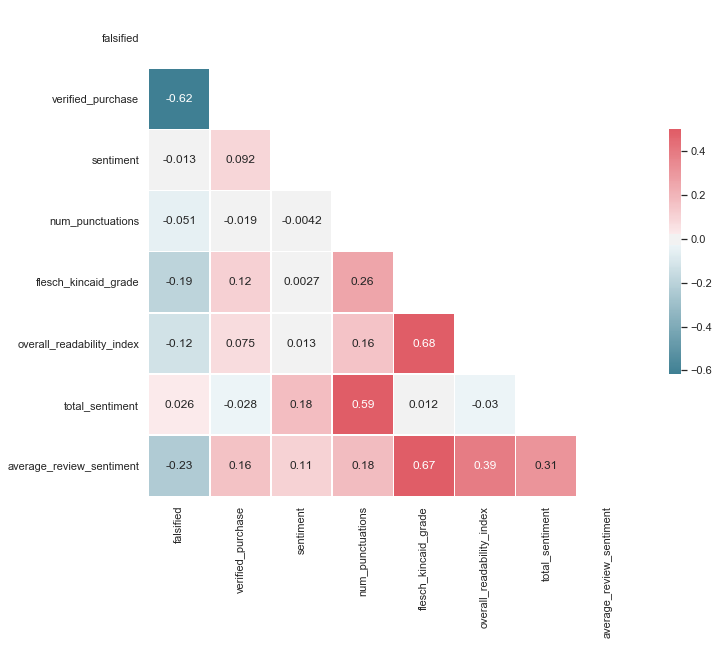

In [384]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#df_corr = df_numerical
df_corr = low_vif_df_numerical

sns.set(style="white")

# Compute the correlation matrix
corr = df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=corr)

<B> Final EDA <b>
    
Now that we have all of our features fully engineered, let's dig into the data.

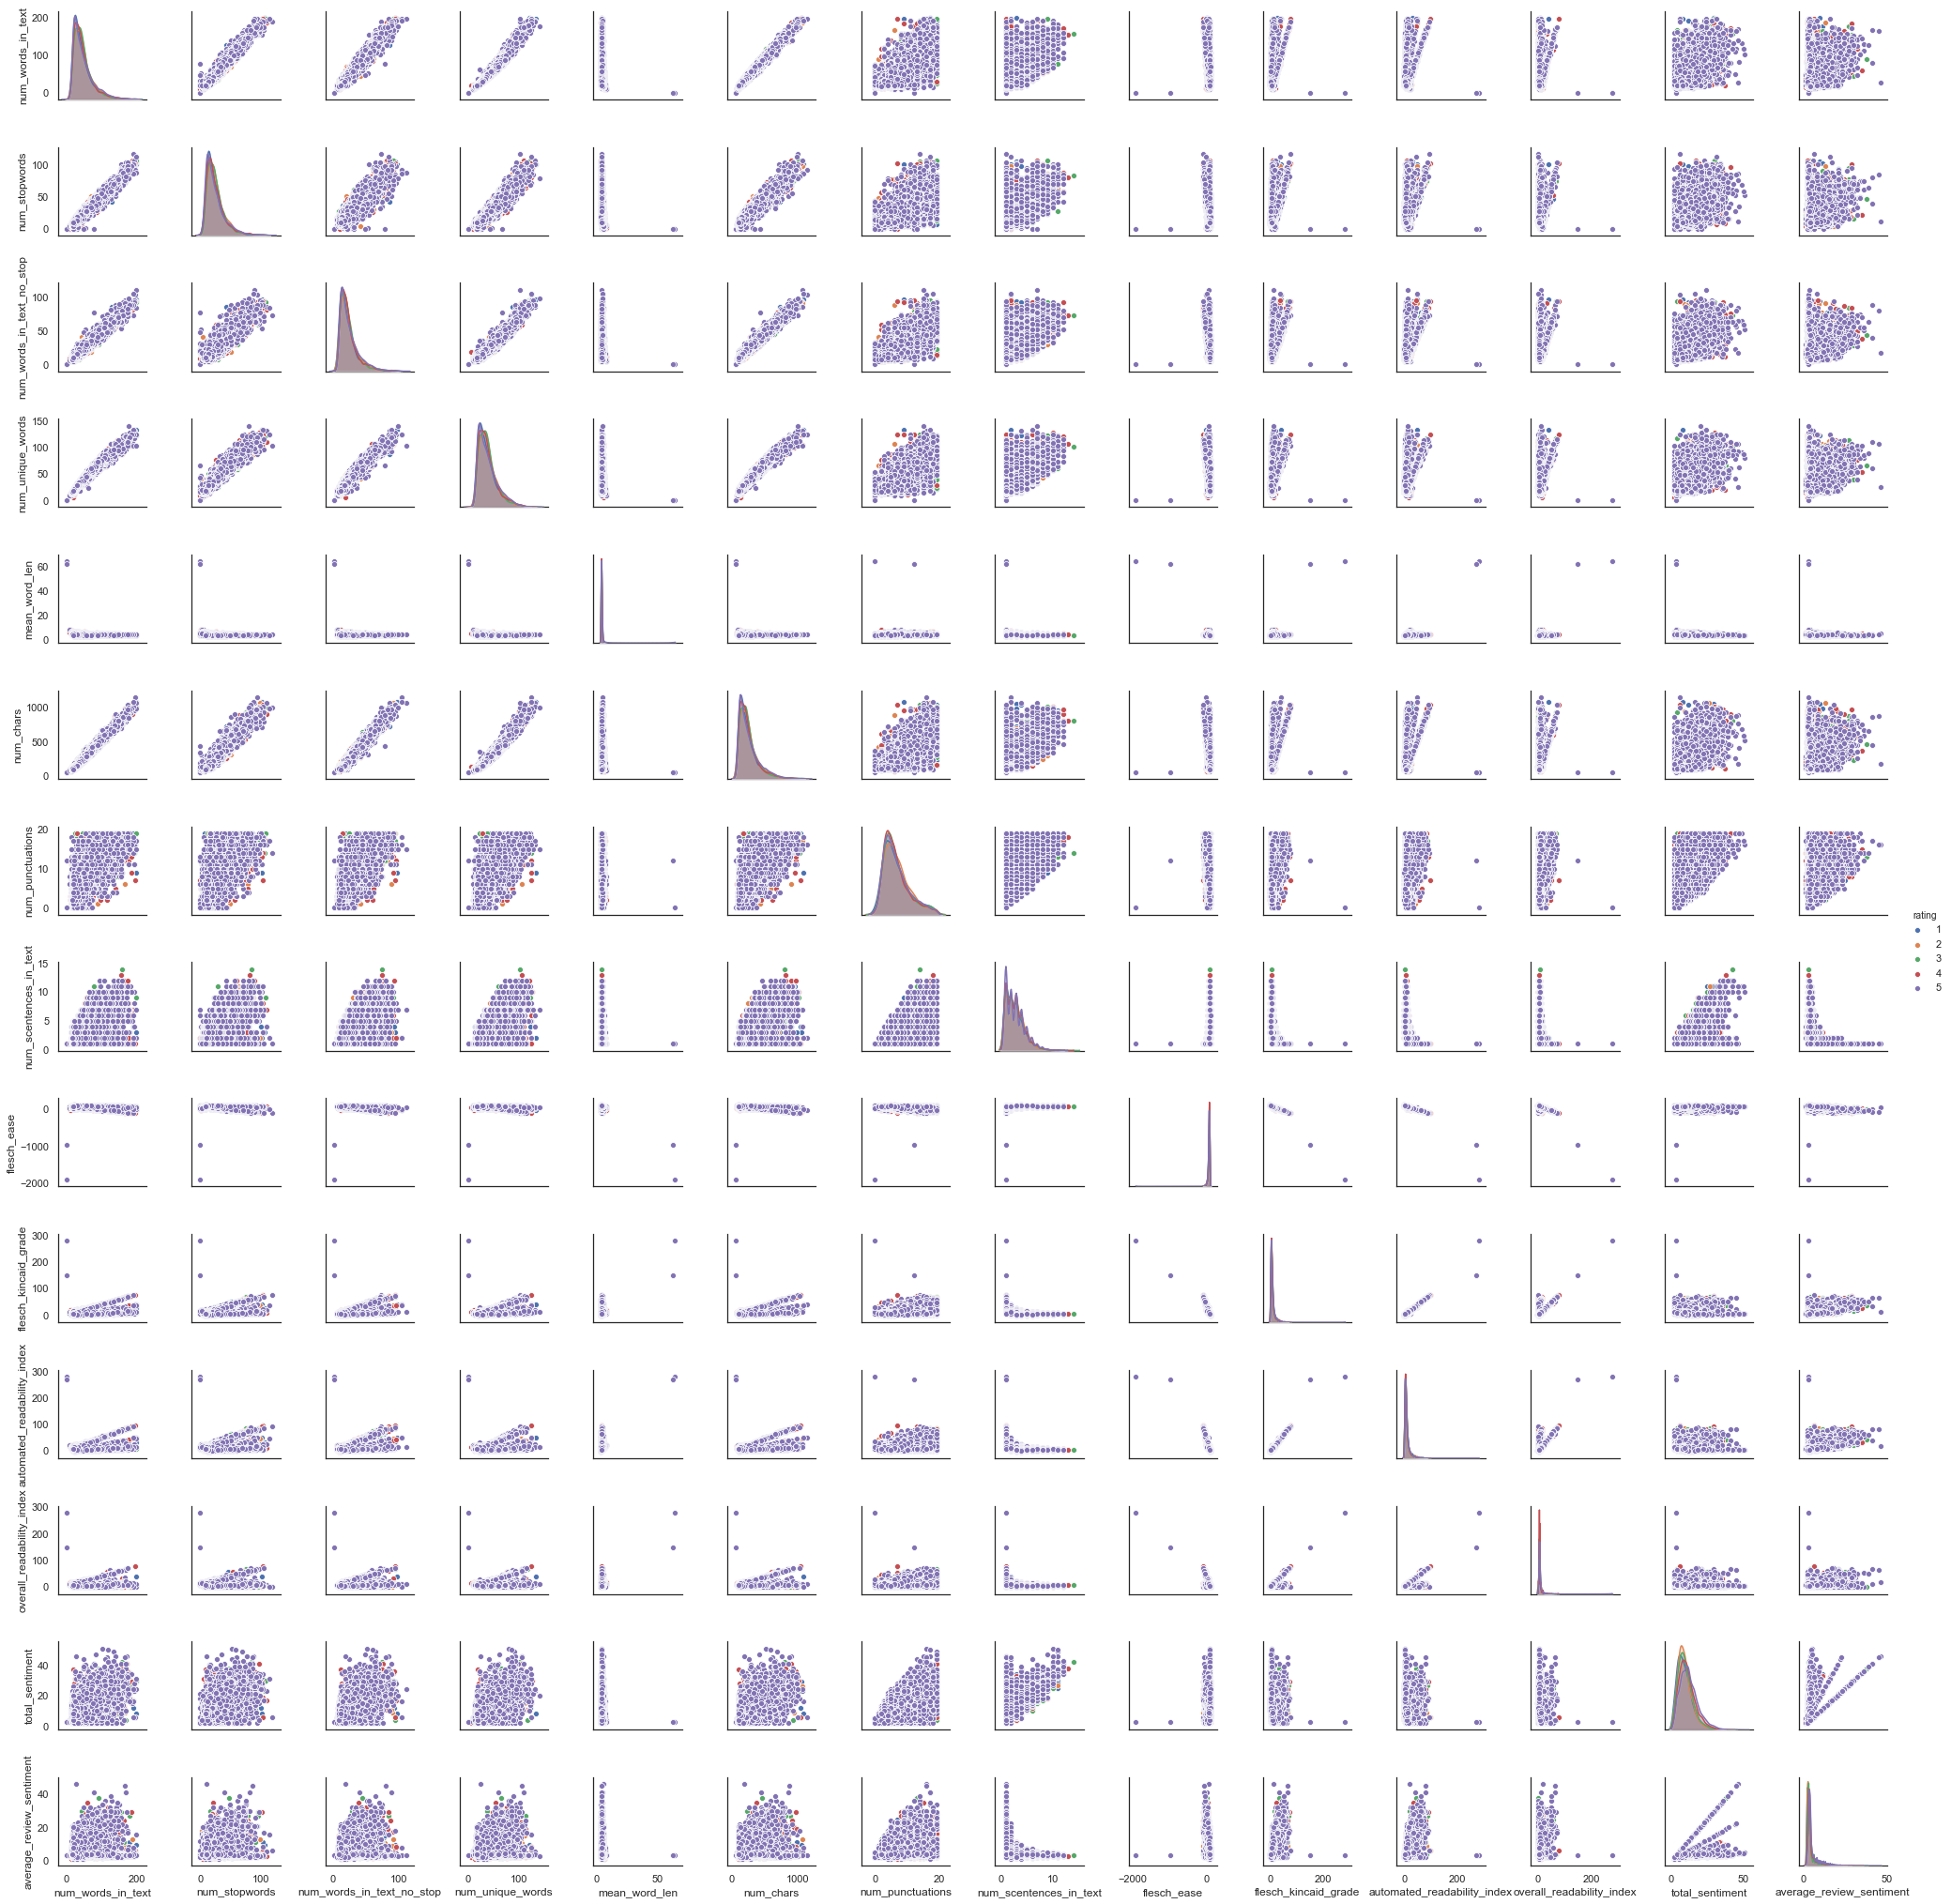

In [385]:
# Let's start by looking at the data using a pairs plot
df_for_pair_plot = df_numerical.drop(columns=['verified_purchase', 'falsified', 'sentiment'])
sns.pairplot(df_for_pair_plot, height=2, kind="scatter", hue='rating');

In [252]:
df_numerical.query('mean_word_len > 50')

,falsified,rating,verified_purchase,sentiment,num_words_in_text,num_stopwords,num_words_in_text_no_stop,num_unique_words,mean_word_len,num_chars,num_punctuations,num_scentences_in_text,flesch_ease,flesch_kincaid_grade,automated_readability_index,overall_readability_index,total_sentiment,average_review_sentiment
12226,0,5,1,1,1,0,1,1,64.00,64,0,1,-1909.19,279.80,280.50,280.00,3.00,3.00
12881,0,5,1,1,1,0,1,1,62.00,62,12,1,-978.59,150.00,271.10,150.00,3.00,3.00


In [253]:
df_final.query('mean_word_len > 50')

,doc_id,falsified,rating,verified_purchase,product_category,product_id,product_title,review_title,review_text_x,sentiment,...,mean_word_len,num_chars,num_punctuations,num_scentences_in_text,flesch_ease,flesch_kincaid_grade,automated_readability_index,overall_readability_index,total_sentiment,average_review_sentiment
12226,12334,0,5,1,Shoes,B000KU6D4M,Ray Ban RB3025 Aviator Sunglasses-002/58 Black (Green Polarized Le...,Perfect,PerfectNãoquerocomentarmaisnadaporfavorissoéridiculollllllllllll,1,...,64.00,64,0,1,-1909.19,279.80,280.50,280.00,3.00,3.00
12881,12998,0,5,1,Camera,B002KP2ZKG,"Ikan Production Slate 9"" x 11""",ok,otimo;;;Nãoquerocomentarmaisnadaporfavorissoéridiculo;;;;;;;;;,1,...,62.00,62,12,1,-978.59,150.00,271.10,150.00,3.00,3.00


In [254]:
df_numerical = df_numerical.query('mean_word_len < 50')

In [255]:
df_numerical.query('mean_word_len > 50')

,falsified,rating,verified_purchase,sentiment,num_words_in_text,num_stopwords,num_words_in_text_no_stop,num_unique_words,mean_word_len,num_chars,num_punctuations,num_scentences_in_text,flesch_ease,flesch_kincaid_grade,automated_readability_index,overall_readability_index,total_sentiment,average_review_sentiment


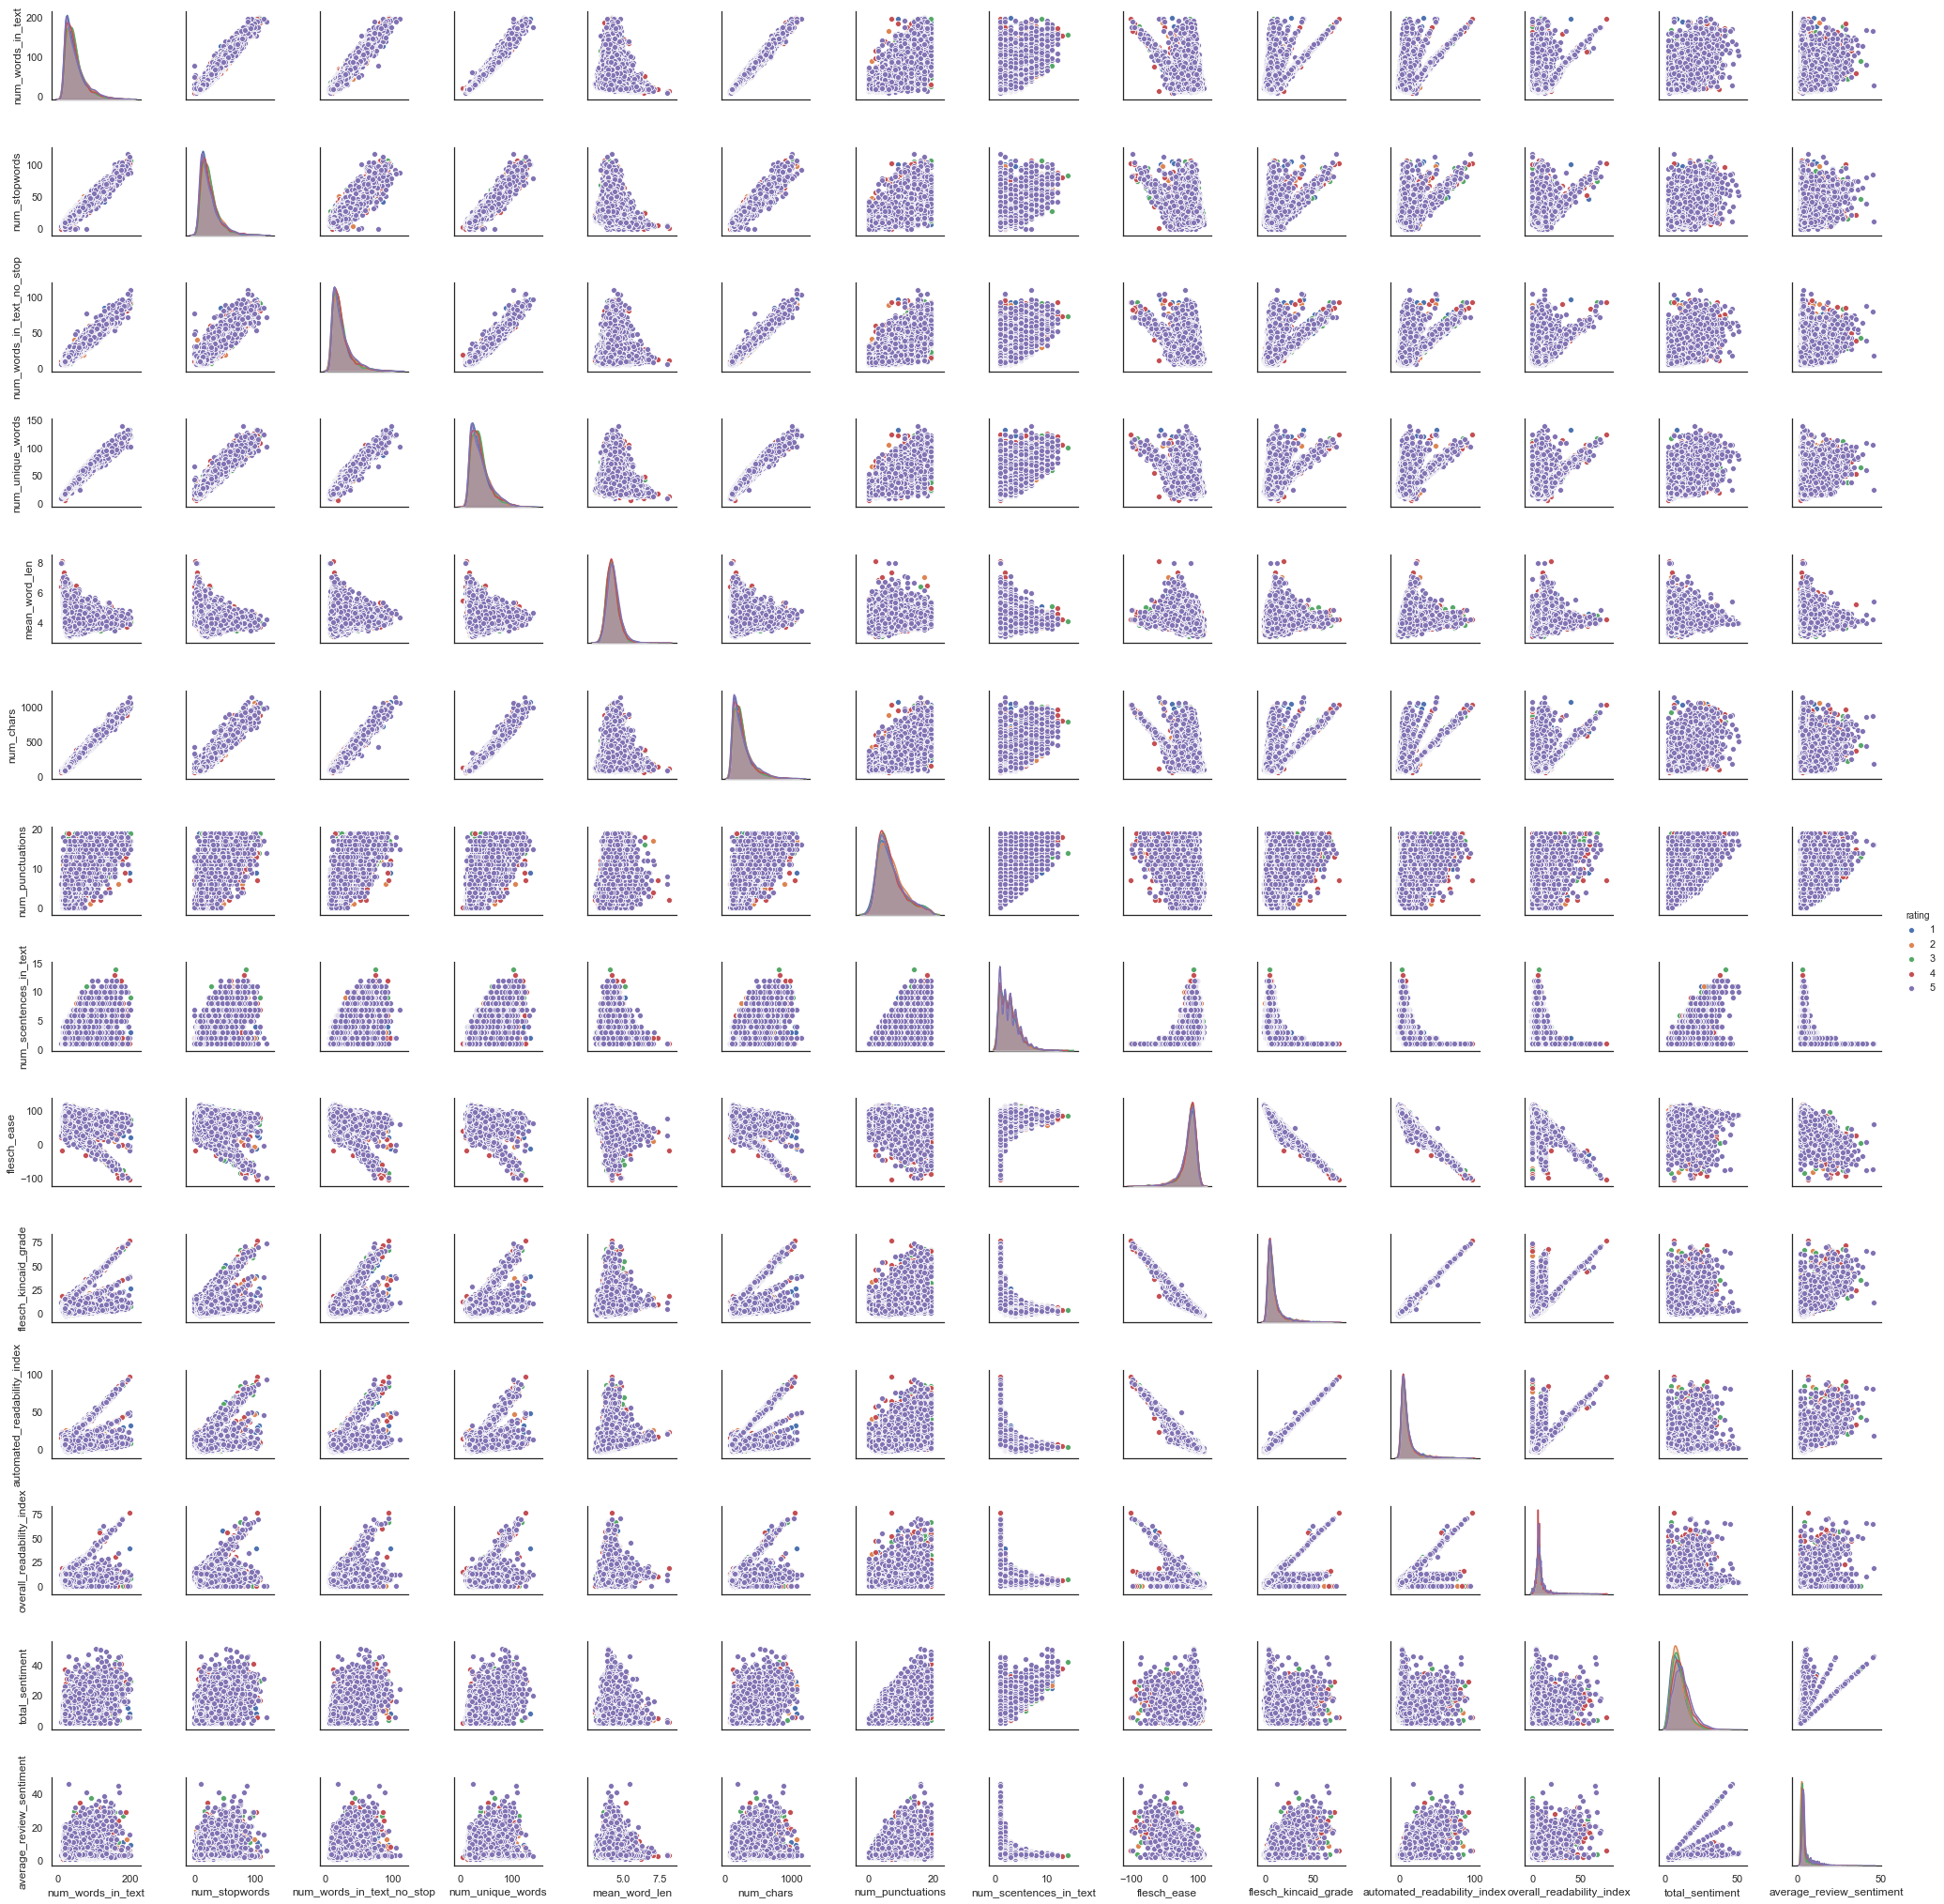

In [237]:
# Let's start by looking at the data using a pairs plot
df_for_pair_plot = df_numerical.drop(columns=['verified_purchase', 'falsified', 'sentiment'])
sns.pairplot(df_for_pair_plot, height=2, kind="scatter", hue='rating');

### 5. Preliminary Modeling

In [275]:
import statsmodels.api as sm

In [276]:
print(low_vif_df_numerical.columns)

Index(['falsified', 'verified_purchase', 'sentiment', 'num_punctuations',
       'flesch_kincaid_grade', 'overall_readability_index', 'total_sentiment',
       'average_review_sentiment'],
      dtype='object')


In [277]:
from sklearn.preprocessing import StandardScaler

#Before Scaling: Pseudo R-squ.:0.3151
#After MinMax Scaling: Pseudo R-squ.:0.3151
#After Standard Scaling: Pseudo R-squ.:0.3151

y = low_vif_df_numerical['falsified']
X = low_vif_df_numerical.drop(columns='falsified')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(y.shape)
print(X.shape)

(18701,)
(18701, 7)


In [278]:
X_withconstant = sm.add_constant(X)

my_logit_results = sm.Logit(y, X_withconstant).fit()
my_logit_results.summary()

Optimization terminated successfully.
         Current function value: 0.458669
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              falsified   No. Observations:                18701
Model:                          Logit   Df Residuals:                    18693
Method:                           MLE   Df Model:                            7
Date:                Tue, 23 Jun 2020   Pseudo R-squ.:                  0.3373
Time:                        10:29:11   Log-Likelihood:                -8577.6
converged:                       True   LL-Null:                       -12943.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.3083      0.067     34.618      0.000       2.178       2.439
verified_purchase            -3.0747      0.043    -71.694      0.000      -3.159      -2.991
sentiment                     0.3475      0.049      7.098      0.000       0.252       0.443
num_punctuations             -0.0938      0.007    -13.656      0.000      -0.107      -0.080
flesch_kincaid_grade          0.0098      0.005      2.130      0.033       0.001       0.019
overall_readability_index    -0.0029      0.005     -0.634      0.526      -0.012       0.006
total_sentiment               0.0647      0.005     13.782      0.000       0.055       0.074
average_review_sentiment     -0.1550      0.008    -18.837      0.000      -0.171      -0.139
=============================================================================================
"""

### 6. Class Imbalance + Downsampling DF

1    14515
0     4186
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Sentiment Counts')

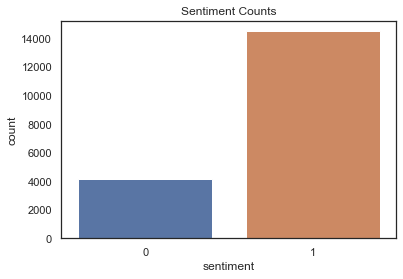

In [279]:
print(low_vif_df_numerical['sentiment'].value_counts())
sns.countplot(x='sentiment', data=low_vif_df_numerical)
plt.title("Sentiment Counts")

In [280]:
1-4817/16183

0.7023419637891615

In [281]:
from sklearn.utils import resample

positive = low_vif_df_numerical[low_vif_df_numerical['sentiment']==1]
negative = low_vif_df_numerical[low_vif_df_numerical['sentiment']==0]

positive_downsampled = resample(positive,
                                replace = False, # sample without replacement
                                n_samples = len(negative), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([positive_downsampled, negative])

df_downsampled = downsampled

1    4186
0    4186
Name: sentiment, dtype: int64


Text(0.5, 1.0, 'Sentiment Counts')

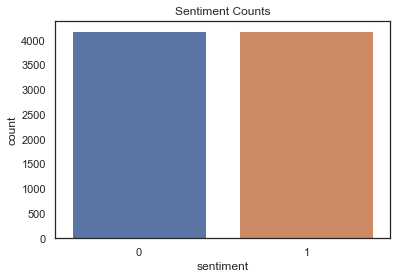

In [282]:
print(df_downsampled['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df_downsampled)
plt.title("Sentiment Counts")

In [283]:
#As this is our fully formed dataset, let's save a backup copy.
df_downsampled.to_csv('df_downsampled.csv');

In [284]:
df_downsampled.shape

(8372, 8)

### 7. Clustering

In [286]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [287]:
# tSNE with two components
y = df_downsampled['falsified']
X = df_downsampled.drop(columns='falsified', axis=1)

# y = df_final['falsified']
# X = df_final.drop(columns='falsified', axis=1)

# We need to scale the data since tSNE is also distance based
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

my_tSNE = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

X_tSNE = my_tSNE.fit_transform(X_scaled)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9104 samples in 0.006s...
[t-SNE] Computed neighbors for 9104 samples in 0.724s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9104
[t-SNE] Computed conditional probabilities for sample 2000 / 9104
[t-SNE] Computed conditional probabilities for sample 3000 / 9104
[t-SNE] Computed conditional probabilities for sample 4000 / 9104
[t-SNE] Computed conditional probabilities for sample 5000 / 9104
[t-SNE] Computed conditional probabilities for sample 6000 / 9104
[t-SNE] Computed conditional probabilities for sample 7000 / 9104
[t-SNE] Computed conditional probabilities for sample 8000 / 9104
[t-SNE] Computed conditional probabilities for sample 9000 / 9104
[t-SNE] Computed conditional probabilities for sample 9104 / 9104
[t-SNE] Mean sigma: 0.226968
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.496231
[t-SNE] KL divergence after 300 iterations: 2.232075


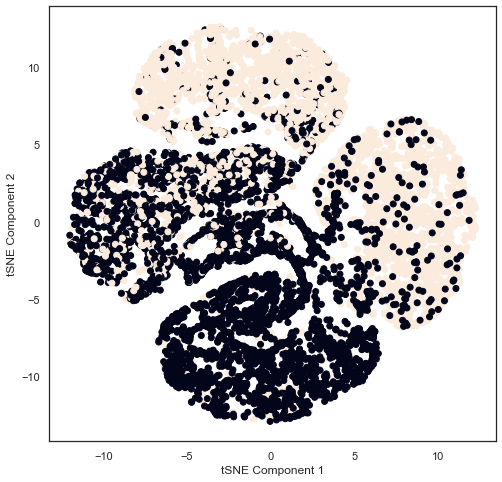

In [288]:
# Plotting the tSNE-transformed data (only the first two dimensions)
plt.figure(figsize=(8, 8))
plt.scatter(X_tSNE[:,0],X_tSNE[:,1],c=y)

plt.xlabel("tSNE Component 1")
plt.ylabel("tSNE Component 2")

plt.show()

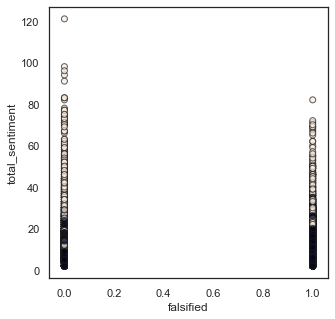

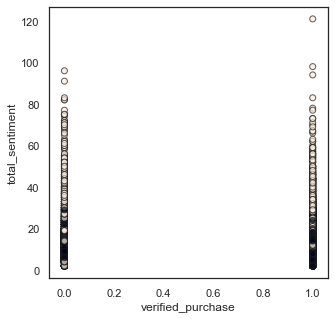

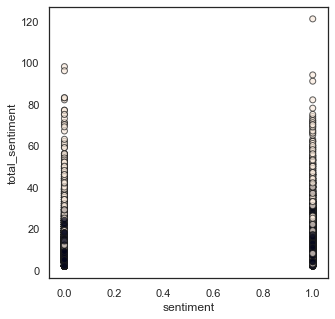

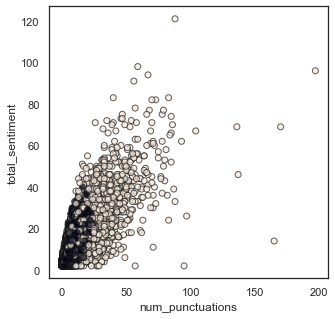

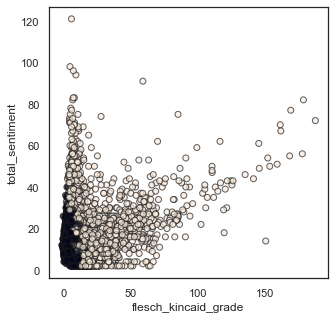

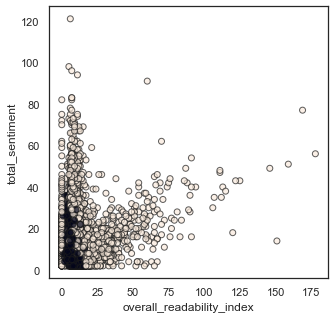

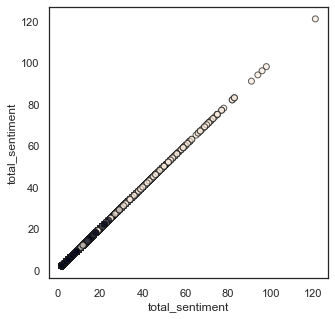

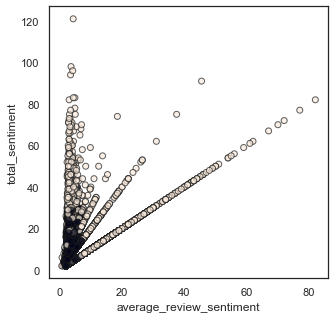

In [51]:
from sklearn.mixture import GaussianMixture

X = df_downsampled
y = df_downsampled['falsified']

#Build and fit the model
my_gmm = GaussianMixture(n_components=2, covariance_type='full')
my_gmm.fit(X)

#Getting the labels
pred_labels_gmm = my_gmm.predict(X)

for column in df_downsampled:
    #Plot the predictions
    plt.figure(figsize=[5,5])
    plt.scatter(x = df_downsampled[column],
                y = df_downsampled['total_sentiment'],
                c=pred_labels_gmm, 
                edgecolor='k',
                alpha=0.7)
    plt.xlabel(column)
    plt.ylabel('total_sentiment')
    plt.show();

### 8. LogReg Odds Ratio + Feature Importance

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

The first step will be to invesitgate to what extent each of the features contribute to increasing or decreasing the chance of a falsified review.

In [336]:
from sklearn.linear_model import LogisticRegression

df_numerical = df_numerical.drop(columns=['num_words_in_text','num_stopwords'])
y = df_numerical['falsified']
X = df_numerical.drop(columns='falsified')

# y = df_downsampled['falsified']
# X = df_downsampled.drop(columns='falsified')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(y.shape)
print(X.shape)

(18701,)
(18701, 15)


In [337]:
display_NA_counts(X)

Series([], dtype: int64)

In [338]:
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [339]:
my_logreg_model_scaled = LogisticRegression(C=1, random_state=1, max_iter=1000).fit(X_scaled_train, y_train)

In [340]:
print(my_logreg_model_scaled.score(X_scaled_test,y_test))

0.7923015236567763


In [341]:
X_withconstant = sm.add_constant(X)

my_logit_results = sm.Logit(y, X_withconstant).fit()
my_logit_results.summary()

Optimization terminated successfully.
         Current function value: 0.456205
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              falsified   No. Observations:                18701
Model:                          Logit   Df Residuals:                    18685
Method:                           MLE   Df Model:                           15
Date:                Tue, 23 Jun 2020   Pseudo R-squ.:                  0.3408
Time:                        10:35:30   Log-Likelihood:                -8531.5
converged:                       True   LL-Null:                       -12943.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          20.3762      3.132      6.507      0.000      14.239      26.514
rating                          0.1192      0.036      3.338      0.001       0.049       0.189
verified_purchase              -3.0890      0.043    -71.431      0.000      -3.174      -3.004
sentiment                       0.0239      0.109      0.221      0.825      -0.189       0.237
num_words_in_text_no_stop      -0.0512      0.007     -6.900      0.000      -0.066      -0.037
num_unique_words                0.0049      0.006      0.807      0.420      -0.007       0.017
mean_word_len                  -1.8296      0.307     -5.958      0.000      -2.431      -1.228
num_chars                       0.0032      0.001      3.505      0.000       0.001       0.005
num_punctuations               -0.0871      0.008    -10.661      0.000      -0.103      -0.071
num_scentences_in_text         -0.0469      0.039     -1.204      0.229      -0.123       0.029
flesch_ease                    -0.1048      0.018     -5.727      0.000      -0.141      -0.069
flesch_kincaid_grade           -0.7564      0.133     -5.672      0.000      -1.018      -0.495
automated_readability_index     0.3951      0.067      5.874      0.000       0.263       0.527
overall_readability_index      -0.0006      0.005     -0.129      0.897      -0.010       0.009
total_sentiment                 0.0932      0.010      9.034      0.000       0.073       0.113
average_review_sentiment       -0.1930      0.015    -13.050      0.000      -0.222      -0.164
===============================================================================================
"""

In [342]:
coefficients = my_logit_results.params
coefficients.head()

const                       20.38
rating                       0.12
verified_purchase           -3.09
sentiment                    0.02
num_words_in_text_no_stop   -0.05
dtype: float64

In [343]:
p_values = my_logit_results.pvalues
p_values.head()

const                       0.00
rating                      0.00
verified_purchase           0.00
sentiment                   0.83
num_words_in_text_no_stop   0.00
dtype: float64

In [344]:
coefficient_df = pd.DataFrame({"coefficient": coefficients,
                               "p-value": p_values})
print(coefficient_df.shape)
coefficient_df.head()

(16, 2)


,coefficient,p-value
const,20.38,0.00
rating,0.12,0.00
verified_purchase,-3.09,0.00
sentiment,0.02,0.83
num_words_in_text_no_stop,-0.05,0.00


In [345]:
coefficient_df.drop('const', axis=0, inplace=True)
coefficient_df.head()

,coefficient,p-value
rating,0.12,0.00
verified_purchase,-3.09,0.00
sentiment,0.02,0.83
num_words_in_text_no_stop,-0.05,0.00
num_unique_words,0.00,0.42


In [346]:
statistically_significant_condition = coefficient_df['p-value'] < 0.05

significant_coefficient_df = coefficient_df.loc[statistically_significant_condition].copy()
significant_coefficient_df.shape

(11, 2)

In [347]:
significant_coefficient_df['abs_coef'] = np.abs(significant_coefficient_df['coefficient'])
significant_coefficient_df = significant_coefficient_df.sort_values(by='abs_coef')
significant_coefficient_df

,coefficient,p-value,abs_coef
num_chars,0.00,0.00,0.00
num_words_in_text_no_stop,-0.05,0.00,0.05
num_punctuations,-0.09,0.00,0.09
total_sentiment,0.09,0.00,0.09
flesch_ease,-0.10,0.00,0.10
rating,0.12,0.00,0.12
average_review_sentiment,-0.19,0.00,0.19
automated_readability_index,0.40,0.00,0.40
flesch_kincaid_grade,-0.76,0.00,0.76
mean_word_len,-1.83,0.00,1.83


In [348]:
significant_coefficient_df['color'] = np.where(significant_coefficient_df['coefficient'] >= 0.0,
                                               'blue', 
                                               'red')
significant_coefficient_df.head()

,coefficient,p-value,abs_coef,color
num_chars,0.00,0.00,0.00,blue
num_words_in_text_no_stop,-0.05,0.00,0.05,red
num_punctuations,-0.09,0.00,0.09,red
total_sentiment,0.09,0.00,0.09,blue
flesch_ease,-0.10,0.00,0.10,red


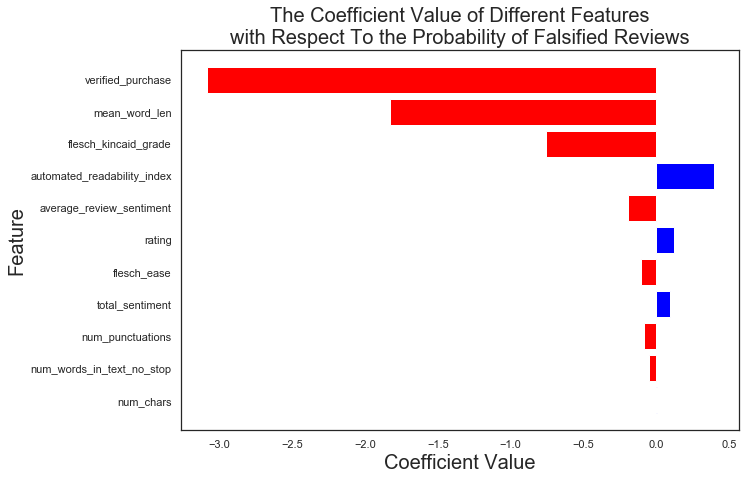

In [349]:
plt.figure(figsize=(10,7))
plt.barh(significant_coefficient_df.index, 
         significant_coefficient_df['coefficient'],
         color=significant_coefficient_df['color'])
plt.title("The Coefficient Value of Different Features\nwith Respect To the Probability of Falsified Reviews",
          size=20)
plt.xlabel("Coefficient Value", size=20)
plt.ylabel("Feature", size=20)
plt.show()

In [350]:
significant_coefficient_df['odds_increase'] = np.where(significant_coefficient_df['coefficient'] > 0,
                                                       np.exp(significant_coefficient_df['coefficient']),
                                                       np.exp(-significant_coefficient_df['coefficient']))
significant_coefficient_df.head() 

,coefficient,p-value,abs_coef,color,odds_increase
num_chars,0.00,0.00,0.00,blue,1.00
num_words_in_text_no_stop,-0.05,0.00,0.05,red,1.05
num_punctuations,-0.09,0.00,0.09,red,1.09
total_sentiment,0.09,0.00,0.09,blue,1.10
flesch_ease,-0.10,0.00,0.10,red,1.11


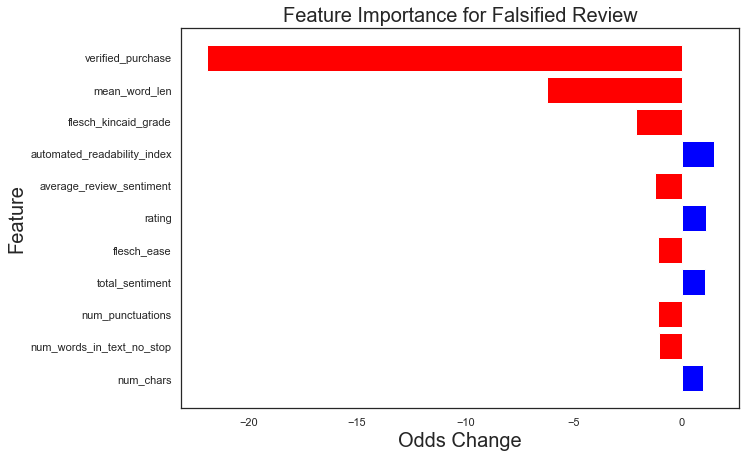

In [351]:
significant_coefficient_df['odds_increase'] = np.where(significant_coefficient_df['coefficient'] > 0,
                                                       significant_coefficient_df['odds_increase'],
                                                       -significant_coefficient_df['odds_increase'])


plt.figure(figsize=(10,7))
plt.barh(significant_coefficient_df.index, 
         significant_coefficient_df['odds_increase'],
         color=significant_coefficient_df['color'])
plt.title("Feature Importance for Falsified Review",
          size=20)
plt.xlabel("Odds Change", size=20)
plt.ylabel("Feature", size=20)
plt.show()

In [352]:
significant_coefficient_df['abs_coef'] = np.abs(significant_coefficient_df['coefficient'])
significant_coefficient_df['p-value'] = np.round(significant_coefficient_df['p-value'], 2)


significant_coefficient_df['odds_increase'] = np.where(significant_coefficient_df['coefficient'] > 0,
                                           np.exp(significant_coefficient_df['coefficient']),
                                           -np.exp(-significant_coefficient_df['coefficient']))

significant_coefficient_df['odds_increase'] = np.round(significant_coefficient_df['odds_increase'],2)


significant_coefficient_df = significant_coefficient_df.sort_values(by=['p-value','abs_coef'], ascending=[False, True])

labels = []
sizes = []
p_values = []
colors = []        # Holds bar colors

p_value_color_scale = 1.5

# iterate through
for index, row in significant_coefficient_df.iterrows():
    
        labels.append(index)
        
        coefficient_value = row['coefficient']
        p_value = row['p-value']
        
        p_values.append(p_value)
        
        size = row['odds_increase']
        sizes.append(size)

        # Red, Green, Blue
        color = [1.0,1.0,1.0]
        
        # Adjust the green value based on the p_value
        p_value_color = min(p_value_color_scale*p_value, 1.0) # values can't be larger than 1.0
        
        color[1] = p_value_color
        
        # Based on the p-value and the sign, we will adjust the color of the bar
        if (coefficient_value >= 0):
            color[0] = color[1]                     # Make RED brighter
        else:
            color[2] = color[1]                     # Make BLUE brighter

        colors.append(color)

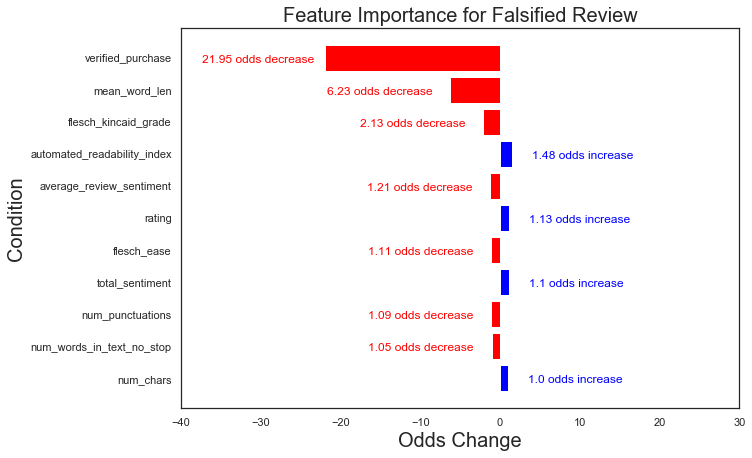

In [353]:
fix, ax = plt.subplots(figsize=(10,7))
ax.barh(labels, sizes, color=colors)

for index, bar_size in enumerate(sizes):
    
    if (bar_size > 0.0):
        # Add a label text
        ax.text(bar_size + 2.5, index-0.15, f'{bar_size} odds increase', color='blue')
        
#         # Add a p-value disclaimer
#         if (p_values[index] >= 0.05):
#             ax.text(-2.5, index-0.15, f'p-value={p_values[index]}', color='blue')
    else:
        # Label text
        ax.text(bar_size - 15.5, index-0.15, f'{abs(bar_size)} odds decrease', color='red')
        
#         # p-value disclaimer
#         if (p_values[index] >= 0.05):
#             ax.text(0.3, index-0.15, f'p-value={p_values[index]}', color='red')

# change the limit to make sure labels go inside the plot area
plt.xlim(-40, 30)

plt.title("Feature Importance for Falsified Review",
          size=20)
plt.xlabel("Odds Change", size=20)
plt.ylabel("Condition", size=20)
plt.show()

### 9. Model Testing and Comparison

#### A. Logistic Regression

The order of operation will be:

------------

1. Train-Test Split
2. Pre-process 
    1. Fit scaler on train data
    2. Transform train data
    3. Transform test data using the same scaler
3. Train model on scaled train data
4. Test model on scaled test data

In [354]:
#Set up X and y
X = df_downsampled.drop('falsified', axis=1)
y = df_downsampled['falsified']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_remainder, X_test, y_remainder, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size = 0.2, 
                                                            stratify = y,
                                                            random_state=1)

In [355]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#Set up X and y
X = df_downsampled.drop('falsified', axis=1)
y = df_downsampled['falsified']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

#Baseline LogReg Model
logreg_model = LogisticRegression( max_iter=10000).fit(X_scaled_train, y_train)

#Score it
print(logreg_model.score(X_scaled_train,y_train))
print(logreg_model.score(X_scaled_test,y_test))

0.8242086402548278
0.8184532696327261


In [356]:
from sklearn.metrics import classification_report

# predict on test set
logreg_pred = logreg_model.predict(X_scaled_test)

report_initial = classification_report(y_test, logreg_pred, digits=4)
print(report_initial)

              precision    recall  f1-score   support

           0     0.7651    0.8800    0.8185      1558
           1     0.8799    0.7649    0.8184      1791

    accuracy                         0.8185      3349
   macro avg     0.8225    0.8225    0.8185      3349
weighted avg     0.8265    0.8185    0.8184      3349



- Now that we have a baseline, let's see if we can optimize the hyperparameter C using cross validation.

In [357]:
#Set up X and y
X = df_downsampled.drop('falsified', axis=1)
y = df_downsampled['falsified']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

# Store the results
validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Do some cross validation
for c in C_range:
    logreg_model = LogisticRegression(C = c,random_state=1, max_iter=10000)
    logreg_model.fit(X_scaled_train, y_train)
    
    # train on traning set
    train_scores.append(logreg_model.score(X_scaled_train, y_train))
    # score on validation set
    validation_scores.append(logreg_model.score(X_scaled_test, y_test))
    

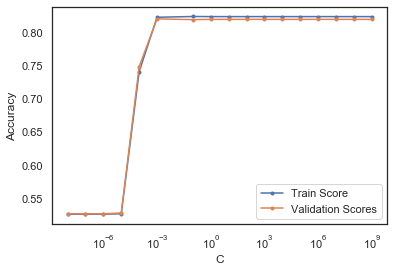

In [358]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [359]:
# Getting our optimal max depth value
C_range[np.argmax(validation_scores)]

0.001

In [360]:
my_final_model = LogisticRegression(C=.001,random_state=1,max_iter=1000)

# Remember that X_remainder and y_remainder held the data I split into train and validation
# I can use that data to re-train my model
my_final_model.fit(X_scaled_train,y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### LOG REG RESULTS

In [361]:
print(my_final_model.score(X_scaled_train,y_train))
print(my_final_model.score(X_scaled_test,y_test))

0.8220136518771332
0.8196656050955414


In [362]:
from sklearn.metrics import classification_report

# predict on test set
logreg_pred = my_final_model.predict(X_scaled_test)

report_initial = classification_report(y_test, logreg_pred, digits=4)
print(report_initial)

              precision    recall  f1-score   support

           0     0.7712    0.8796    0.8219      1188
           1     0.8764    0.7659    0.8174      1324

    accuracy                         0.8197      2512
   macro avg     0.8238    0.8227    0.8196      2512
weighted avg     0.8267    0.8197    0.8195      2512



In [198]:
from sklearn.metrics import confusion_matrix

confusion_matrix_logreg = confusion_matrix(y_test, logreg_pred)

pd.DataFrame(data=confusion_matrix_logreg,
            index = ["Predicted non-Falsified", "Predicted Falsified"],
            columns = ["True Non-Falsified", "True Falsified"])

,True Non-Falsified,True Falsified
Predicted non-Falsified,1045,143
Predicted Falsified,310,1014


In [199]:
y_test.shape

(2512,)

#### B. K-Nearest Neighbors

In [200]:
from sklearn.neighbors import KNeighborsClassifier

# y = df_numerical['falsified']
# X = df_numerical.drop(columns='falsified')

y = df_downsampled['falsified']
X = df_downsampled.drop(columns='falsified')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Instantiate the model & fit it to our data
KNN_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
KNN_model.fit(X_train, y_train)

# Score the model on the test set
train_predictions = KNN_model.predict(X_train)
test_predictions = KNN_model.predict(X_test)

train_accuracy = accuracy_score(train_predictions, y_train)
test_accuracy = accuracy_score(test_predictions, y_test)

print(f"Train set accuracy: {train_accuracy}")
print(f"Test set accuracy: {test_accuracy}")

Train set accuracy: 0.9953710616694043
Test set accuracy: 0.697910447761194


In [201]:
# Define hyperparameters to search over
dt_params = { 'n_neighbors':list(range(1,15)), 
              'leaf_size': list(range(1,15))
            }

In [202]:
from sklearn.model_selection import GridSearchCV

# Initiate the DT grid search
gs_knnmodel = GridSearchCV(estimator=KNeighborsClassifier(), \
                          param_grid=dt_params, cv=5, n_jobs=-1, verbose=0)

# Fit the DT grid search
gs_knnmodel_fitted = gs_knnmodel.fit(X_test, y_test)

In [203]:
# Show the best estimators
gs_knnmodel_fitted.best_params_

{'leaf_size': 1, 'n_neighbors': 14}

##### KNN RESULTS

In [204]:
# Let's see if our accuracy improved
print(gs_knnmodel_fitted.score(X_train, y_train))
print(gs_knnmodel_fitted.score(X_test, y_test))

0.6683589667015082
0.7229850746268657


In [205]:
# predict on test set
knn_pred = gs_knnmodel_fitted.predict(X_test)

In [206]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, knn_pred, digits=4)
print(report_initial)

              precision    recall  f1-score   support

           0     0.7051    0.7015    0.7033       784
           1     0.7385    0.7419    0.7402       891

    accuracy                         0.7230      1675
   macro avg     0.7218    0.7217    0.7218      1675
weighted avg     0.7229    0.7230    0.7229      1675



#### E. Support Vector Machines

In [49]:
from sklearn.svm import LinearSVC

y = df_downsampled['falsified']
X = df_downsampled.drop(columns='falsified')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

SVM_model = LinearSVC(max_iter=10000)
SVM_model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

##### SVM RESULTS

In [50]:
print(f"The TRAIN classification accuracy is: {SVM_model.score(X_train,y_train)}")
print(f"The TEST classification accuracy is: {SVM_model.score(X_test,y_test)}")

The TRAIN classification accuracy is: 0.8177966101694916
The TEST classification accuracy is: 0.8191800878477306


In [51]:
# predict on test set
svn_pred = SVM_model.predict(X_test)

In [53]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, svn_pred, digits=4)
print(report_initial)

              precision    recall  f1-score   support

           0     0.7841    0.8678    0.8238      1331
           1     0.8602    0.7730    0.8143      1401

    accuracy                         0.8192      2732
   macro avg     0.8222    0.8204    0.8191      2732
weighted avg     0.8231    0.8192    0.8189      2732



In [ ]:
from sklearn.svm import SVC

y = df_downsampled['falsified']
X = df_downsampled.drop(columns='falsified')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Instantiate the model
my_RBF_kernel_SVM = SVC()
my_linear_kernel_SVM = SVC(kernel='linear', C=1000)

#Fit the data
my_linear_kernel_SVM.fit(X_train, y_train)

#Get the score
print(f"Linear SVM score (train): {my_linear_kernel_SVM.score(X_train,y_train)}")
print(f"Linear SVM score (test): {my_linear_kernel_SVM.score(X_test,y_test)}")

In [59]:
# Define hyperparameters to search over
kernel_SVM_params = { 'C':list([.0001,.001,0.1,1,10,100,1000,10000,100000,]), 
                      'kernel': list(['linear', 'poly', 'rbf', 'sigmoid'])
                    }

In [61]:
# Initiate the DT grid search
ksvm = GridSearchCV(estimator=SVC(random_state = 1), \
                          param_grid=kernel_SVM_params, cv=5, n_jobs=-1, verbose=0)

# Fit the DT grid search
ksvm_model_fitted = ksvm.fit(X_test, y_test)

KeyboardInterrupt: 

In [ ]:
# Show the best estimators
ksvm_model_fitted.best_params_

In [ ]:
# predict on test set
ksvm_model_fitted = my_linear_kernel_SVM.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, ksvm_model_fitted, digits=4)
print(report_initial)

#### C. Decision Tree
- Decision trees work well with imbalanced data.
- <mark>"How" each model makes decions (decisions trees at each nodes)<mark>

In [207]:
from sklearn.tree import DecisionTreeClassifier

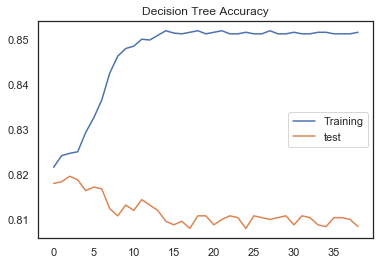

In [208]:
training_scores = []
test_scores = []

y = df_downsampled['falsified']
X = df_downsampled.drop(columns='falsified')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

for i in range(1,40):
    # Instantiate & fit the DT
    DT_model = DecisionTreeClassifier(max_depth=i, max_leaf_nodes=100)
    DT_model.fit(X_train, y_train)
    
    training_scores.append(DT_model.score(X_train, y_train))
    test_scores.append(DT_model.score(X_test, y_test))

plt.figure()
plt.title('Decision Tree Accuracy')
plt.plot(training_scores)
plt.plot(test_scores)
plt.legend(['Training', 'test'])

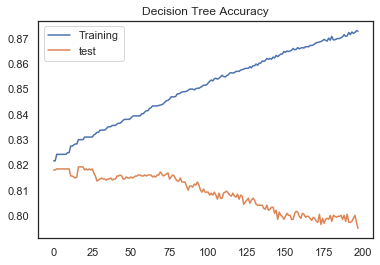

In [209]:
training_scores = []
test_scores = []

for i in range(2,200):
    # Instantiate & fit the DT
    DT_model = DecisionTreeClassifier(max_depth=19, max_leaf_nodes=i)
    DT_model.fit(X_train, y_train)
    
    training_scores.append(DT_model.score(X_train, y_train))
    test_scores.append(DT_model.score(X_test, y_test))

plt.figure()
plt.title('Decision Tree Accuracy')
plt.plot(training_scores)
plt.plot(test_scores)
plt.legend(['Training', 'test'])

In [210]:
# Instantiate & fit the DT
DT_model = DecisionTreeClassifier(max_depth = 4, max_leaf_nodes=14)
DT_model.fit(X_train, y_train) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=14,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

##### DT RESULTS

In [211]:
# Evaluate its classification accuracy (Just on the training set for now)
print(f"DT training set accuracy: {DT_model.score(X_train, y_train)}")
print(f"DT test set accuracy: {DT_model.score(X_test, y_test)}")

DT training set accuracy: 0.8250853242320819
DT test set accuracy: 0.8196656050955414


- Now that we have an optimized Decision Tree, let's see a grid search can conclude our results.

In [212]:
# Define hyperparameters to search over
dt_params = { 'max_depth':list(range(1,11)), 
              'min_samples_leaf': list(range(1,11)),
              'max_leaf_nodes': list(range(1,20))}

In [69]:
# Initiate the DT grid search
gs_dtmodel = GridSearchCV(estimator=DecisionTreeClassifier(random_state = 1), \
                          param_grid=dt_params, cv=5, n_jobs=-1, verbose=0)

# Fit the DT grid search
gs_dtmodel_fitted = gs_dtmodel.fit(X_test, y_test)

In [70]:
# Show the best estimators
gs_dtmodel_fitted.best_params_

{'max_depth': 3, 'max_leaf_nodes': 7, 'min_samples_leaf': 1}

In [71]:
# Let's see if our accuracy improved
print(gs_dtmodel_fitted.score(X_test, y_test))
print(gs_dtmodel_fitted.score(X_train, y_train))

0.8224743777452416
0.8181104833647207


In [72]:
# Instantiate & fit the DT
DT_model = DecisionTreeClassifier(max_depth = 6, max_leaf_nodes=16, min_samples_leaf=1)
DT_model.fit(X_train, y_train) 

# Evaluate its classification accuracy (Just on the training set for now)
print(f"The DT TRAINING set accuracy: {DT_model.score(X_train, y_train)}")
print(f"The DT TEST set accuracy: {DT_model.score(X_test, y_test)}")

DT training set accuracy: 0.8223477715003139
DT test set accuracy: 0.8195461200585652


In [73]:
from sklearn.metrics import classification_report

# predict on test set
dt_pred = DT_model.predict(X_test)

report_initial = classification_report(y_test, dt_pred, digits=4)
print(report_initial)

              precision    recall  f1-score   support

           0     0.7808    0.8753    0.8254      1331
           1     0.8661    0.7666    0.8133      1401

    accuracy                         0.8195      2732
   macro avg     0.8235    0.8209    0.8193      2732
weighted avg     0.8246    0.8195    0.8192      2732



#### D. Random Forest Classifier

In [363]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV

y = df_downsampled['falsified']
X = df_downsampled.drop(columns='falsified')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

# Let's check our accuracy
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

0.9815699658703072
0.7874203821656051


- Lets see if we can optimize a few hyper parameters

In [364]:
# Define hyperparameters to search over
rfc_params = { 'n_estimators':list(range(1,11)), 
               'min_samples_split': list(range(1,11)),
               'min_samples_leaf':list(range(1,11)),
               'max_leaf_nodes':list(range(1,11)) }

In [365]:
# Initiate the DT grid search
rfc2 = GridSearchCV(estimator=RandomForestClassifier(random_state = 1), \
                          param_grid=rfc_params, cv=5, n_jobs=-1, verbose=0)

# Fit the DT grid search
gs_rfcmodel_fitted = rfc2.fit(X_train, y_train)

In [366]:
# Show the best estimators
gs_rfcmodel_fitted.best_params_

{'max_leaf_nodes': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2}

##### RFC RESULTS

In [367]:
# Let's see if our accuracy improved
print(gs_rfcmodel_fitted.score(X_train, y_train))
print(gs_rfcmodel_fitted.score(X_test, y_test))

0.8252559726962457
0.820859872611465


In [368]:
# predict on test set
rfc_pred = rfc2.predict(X_test)

In [369]:
from sklearn.metrics import classification_report

# predict on test set
rfc_pred = rfc2.predict(X_test)

report_initial = classification_report(y_test, rfc_pred, digits=4)
print(report_initial)

              precision    recall  f1-score   support

           0     0.7690    0.8880    0.8242      1188
           1     0.8833    0.7606    0.8174      1324

    accuracy                         0.8209      2512
   macro avg     0.8261    0.8243    0.8208      2512
weighted avg     0.8292    0.8209    0.8206      2512



In [370]:
from sklearn.metrics import confusion_matrix

# predict on test set
rfc_pred = rfc2.predict(X_test)

confusion_matrix = confusion_matrix(y_test, rfc_pred)

In [371]:
pd.DataFrame(data=confusion_matrix,
            index = ["Predicted non-Falsified", "Predicted Falsified"],
            columns = ["True Non-Falsified", "True Falsified"])

,True Non-Falsified,True Falsified
Predicted non-Falsified,1055,133
Predicted Falsified,317,1007


<b> Where did we get it wrong? <b>

Another important question we need to ask, is where did we get it wrong. Rather than just look at accuracy.

In [36]:
# for idx, prediction, label in zip(enumerate(X_test), rfc_pred, y_test):
#     if prediction != label:
#         print("Sample", idx, ', has been classified as', prediction, 'and should be', label) 

In [37]:
# # with the following sentence you can get a mask of the items bad classified
# mask = np.logical_not(np.equal(y_test, rfc_pred))
# # Now you can use the mask to see the elements bad classified:
# print(f"Elements wrongly classified: {X_test[mask]}")
# print(f"Prediction by the model for each of those elements: {rfc_pred[mask]}")
# print(f"Actual value for each of those elements: {np.asarray(y_test)[mask]}")

In [ ]:
pd.set_option('display.max_colwidth', None)
# Looks good! Let's reset the setting
# pd.set_option('display.max_colwidth', 70)

In [156]:
df_final.query('flesch_kincaid_grade == 59.4 and num_punctuations == 20 and overall_readability_index == 0.00')[:1][:]

,doc_id,falsified,rating,verified_purchase,product_category,product_id,product_title,review_title,review_text_x,sentiment,...,mean_word_len,num_chars,num_punctuations,num_scentences_in_text,flesch_ease,flesch_kincaid_grade,automated_readability_index,overall_readability_index,total_sentiment,average_review_sentiment
20121,20287,0,5,1,Wireless,B00HQ2GYT6,"Stylus, amPen Hybrid 3-in-1 Stylus for iPad/2/3/4, iPad Air, iPad Mini 2/4, iPhone, Galaxy Phone, Galaxy Tab, and any Touchscreen Smartphone or Tablet - (Tips are Replaceable) Silver",Great Stylus! Highly recommended.,"This is a great stylus. It moves smoothly and my iPad is very responsive to it. There is no comparison between this and a rubber tipped stylus. In addition, the larger stylus tip is replaceable. The pen writes smoothly as well.My only complaint is that the clip broke off right away. It is much too tight. Don't plan on clipping this stylus to anything... not even your shirt pocket. This complaint is completely overshadowed by the impressive functionality of the stylus so I still give it 5 stars.Updated: TechMatte sent an email asking me for feedback on their product and services. I mentioned the issue with the clip breaking. They said the problem had been fixed on a updated model of the stylus. They promptly sent me replacement styli free. The replacements have no issues with the clips and otherwise are just as good as the originals.",1,...,4.75,856,20,1,-69.28,59.40,74.40,0.00,35.00,35.00


### 10. Model Compairsion

Model| Accuracy | Precision | Recall | F1-score | 
------------- | ------------- | ------------- | ------------- | ------------- |
<mark><b>Logistic Regression<b><mark>| 82.21% | 82.58%  |    82.53%   |   82.19% |
KNN | 76.13%   |   76.58%   |   76.29% | 76.09%|
SVM | 81.92%   |   82.31%    |  81.92% | 81.89% |
Random Forest Classifier | 81.59%    |  82.60%  |    81.95% | 81.90%


### 10. Random Forest Model Tuning and Selection (DELETE?)

In [178]:
#from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [209]:
# y = df_downsampled['falsified']
# X = df_downsampled.drop(columns='falsified')

y = df_numerical['falsified']
X = df_numerical.drop(columns='falsified')

X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=1)

In [210]:
my_pipeline = Pipeline([('scalar', StandardScaler()), ('dim_reducer', PCA()), ('model', RandomForestClassifier)])

In [211]:
# Parameter grid 
dt_params2 = [
    
    #without PCA 
    {'scalar': [None], 
    'dim_reducer' : [None],
    'model' : [RandomForestClassifier(random_state = 1)], 
    'model__max_depth' : list(range(1,11))},
               
    #with PCA 
    {'scalar' : [StandardScaler(), MinMaxScaler()],
    'dim_reducer' : [PCA()],
    'dim_reducer__n_components' : [.95,0.90,.85,0.8],
    'model' : [RandomForestClassifier(random_state=1)],
    'model__max_depth' : list(range(1,11))}
]

In [212]:
gs_dtmodel2 = GridSearchCV(my_pipeline, param_grid = dt_params2, cv = 5)

In [213]:
gs_dtmodels2_fitted = gs_dtmodel2.fit(X_remainder, y_remainder)

In [214]:
gs_dtmodels2_fitted.best_params_

{'dim_reducer': None,
 'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=10, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=1, verbose=0,
                        warm_start=False),
 'model__max_depth': 10,
 'scalar': None}

In [215]:
print(gs_dtmodels2_fitted.score( X_remainder, y_remainder))
print(gs_dtmodels2_fitted.score( X_test, y_test))

0.8362938070091215
0.7956473035685709
